In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: BMI_IDAP


In [2]:
from pathlib import Path
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import numpy as np
import sklearn.manifold
import sklearn.cluster
import seaborn as sns
import pandas as pd
import sparse
import cv2


import gc
from tqdm.notebook import tqdm
import copy
import time
import random

In [3]:
# only needed if using cuml's TSNE instead of sklearn's
pref_useCuml = False

if pref_useCuml:
    import cuml
    import cuml.manifold

In [4]:
dir_github = Path(r'D:\RH_local\github').resolve()

import sys
# sys.path.append("/n/data1/hms/neurobio/sabatini/rich/github_repos/")
# sys.path.append("/media/rich/Home_Linux_partition/github_repos/")
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

In [5]:
dir_allOuterFolders = Path(r"D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6").resolve()

folders_allSessions = path_helpers.get_dir_contents(dir_allOuterFolders)[0]

# folders_toUse = folders_allSessions[:2]
folders_toUse = list(map(folders_allSessions.__getitem__, [0,1]))


dir_allS2pFolders = [dir_allOuterFolders / folder / 'exp' / 'suite2p' / 'plane0' for folder in folders_toUse]

pathSuffixToStat = "stat.npy"
pathSuffixToOps = "ops.npy"

paths_allStat = [path / pathSuffixToStat for path in dir_allS2pFolders]
paths_allOps  = [path / pathSuffixToOps for path in dir_allS2pFolders]

display(folders_allSessions)
display(folders_toUse)
display(dir_allS2pFolders)
display(paths_allStat)

['20210409',
 '20210410',
 '20210410_test',
 '20210411',
 '20210416',
 '20210417',
 '20210418']

['20210409', '20210410']

[WindowsPath('D:/RH_local/data/scanimage data/round 5 experiments/mouse 2_6/20210409/exp/suite2p/plane0'),
 WindowsPath('D:/RH_local/data/scanimage data/round 5 experiments/mouse 2_6/20210410/exp/suite2p/plane0')]

[WindowsPath('D:/RH_local/data/scanimage data/round 5 experiments/mouse 2_6/20210409/exp/suite2p/plane0/stat.npy'),
 WindowsPath('D:/RH_local/data/scanimage data/round 5 experiments/mouse 2_6/20210410/exp/suite2p/plane0/stat.npy')]

In [6]:
ops = [np.load(path, allow_pickle=True)[()] for path in paths_allOps]

In [7]:
def apply_CLAHE(images, clipLimit=40):
    clahe = cv2.createCLAHE(clipLimit = clipLimit)
    ims_clahe = [(255*im/im.max()).astype(np.uint8) for im in images]
    return ims_clahe

In [8]:
meanIms = [ops[ii]['meanImgE'] for ii in range(len(ops))]
meanIms = apply_CLAHE(meanIms, clipLimit=40)

frame_height = meanIms[0].shape[0]
frame_width = meanIms[0].shape[1]

In [9]:
def display_toggle_image_stack(images, clim=None):
    from ipywidgets import interact, widgets

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    imshow_FOV = ax.imshow(
        images[0],
#         vmax=clim[1]
    )

    def update(i_frame = 0):
        fig.canvas.draw_idle()
        imshow_FOV.set_data(images[i_frame])
        imshow_FOV.set_clim(clim)


    interact(update, i_frame=widgets.IntSlider(min=0, max=len(images)-1, step=1, value=0));

<IPython.core.display.Javascript object>


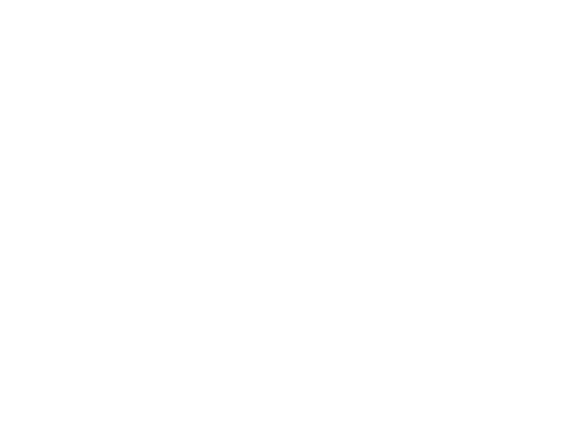

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [10]:
%matplotlib notebook
display_toggle_image_stack(meanIms, clim=None)

## Make spatial_footprints
Make a lazy list of all the spatial_footprints

In [11]:
def import_and_convert_to_CellReg_spatialFootprints(
    paths_statFiles, 
    frame_height=512, 
    frame_width=1024,
    dtype=np.uint8,
    ):
    """
    Imports and converts multiple stat files to spatial footprints
     suitable for CellReg.
    Output will be a list of arrays of shape (n_roi, height, width).
    RH 2022
    """

    isInt = np.issubdtype(dtype, np.integer)

    stats = [np.load(path, allow_pickle=True) for path in paths_statFiles]
    num_rois = [stat.size for stat in stats]
    sf_all_list = [np.zeros((n_roi, frame_height, frame_width), dtype) for n_roi in num_rois]
    for ii, stat in enumerate(stats):
        for jj, roi in enumerate(stat):
            lam = np.array(roi['lam'])
            if isInt:
                lam = dtype(lam / lam.sum() * np.iinfo(dtype).max)
            else:
                lam = lam / lam.sum()
            sf_all_list[ii][jj, roi['ypix'], roi['xpix']] = lam
    return sf_all_list

In [12]:
sf_all = import_and_convert_to_CellReg_spatialFootprints(paths_allStat, frame_height=frame_height, frame_width=frame_width, dtype=np.float32)

## Save spatial_footprints as sparse matrices
I hate this code, but it's necessary to remain low(ish) memory when saving

In [13]:
def register_ROIs(templateFOV, FOVs, ROIs, return_sparse=False, normalize=True):
    dims = templateFOV.shape
    x_grid, y_grid = np.meshgrid(np.arange(0., dims[1]).astype(np.float32), np.arange(0., dims[0]).astype(np.float32))

    template_norm = np.uint8(templateFOV * (templateFOV > 0) * (1/templateFOV.max()) * 255)
    FOVs_norm    = [np.uint8(FOVs[ii] * (FOVs[ii] > 0) * (1/FOVs[ii].max()) * 255) for ii in range(len(FOVs))]

    
    ROIs_aligned, FOVs_aligned, flows = [], [], []
    for ii in range(len(FOVs)):
#         flow = cv2.calcOpticalFlowFarneback(template_norm, FOVs_norm[ii], None,
#                                             0.5, 3, 128, 3, 7, 1.5, 0)
#         flow = cv2.calcOpticalFlowFarneback(
#             prev=template_norm,
#             next=FOVs_norm[ii], 
#             flow=None, 
#             pyr_scale=0.3, 
#             levels=3,
#             winsize=128, 
#             iterations=7,
#             poly_n=7, 
#             poly_sigma=1.5,
#             flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN
#         )
    
        flow = cv2.optflow.createOptFlow_DeepFlow().calc(
            template_norm,
            FOVs_norm[ii],
            None
        )
            
        x_remap = (flow[:, :, 0] + x_grid).astype(np.float32)
        y_remap = (flow[:, :, 1] + y_grid).astype(np.float32)

        ROI_aligned = np.stack([cv2.remap(img.astype(np.float32), x_remap, y_remap, cv2.INTER_NEAREST) for img in ROIs[ii]], axis=0)
#         ROI_aligned = np.stack([img.astype(np.float32) for img in ROIs[ii]], axis=0)
        FOV_aligned = cv2.remap(FOVs_norm[ii], x_remap, y_remap, cv2.INTER_NEAREST)

        if normalize:
            ROI_aligned = ROI_aligned / np.sum(ROI_aligned, axis=(1,2), keepdims=True)
        
        if return_sparse:
            ROIs_aligned.append(scipy.sparse.csc_matrix(ROI_aligned.reshape(ROI_aligned.shape[0], -1)))
            FOVs_aligned.append(FOV_aligned)
            flows.append(flow)
        else:
            ROIs_aligned.append(ROI_aligned)
            FOVs_aligned.append(FOV_aligned)
            flows.append(flow)
    return ROIs_aligned, FOVs_aligned, flows

In [14]:
ROIs_aligned, FOVs_aligned, flows = register_ROIs(meanIms[0], meanIms, sf_all, return_sparse=True, normalize=True)

In [15]:
## remove NaNs from ROIs
for ii in range(len(ROIs_aligned)):
    ROIs_aligned[ii].data[np.isnan(ROIs_aligned[ii].data)] = 0

Check to make sure the FOVs look aligned

<IPython.core.display.Javascript object>


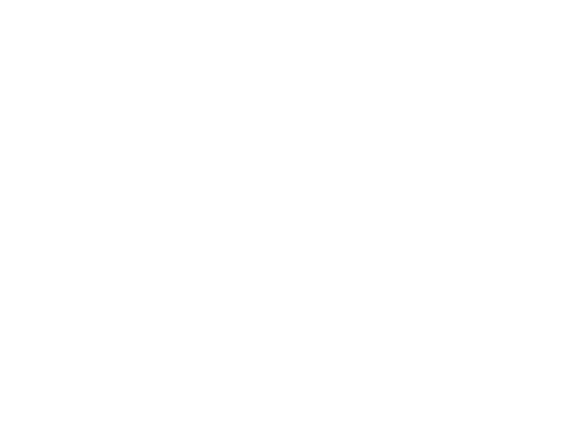

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [16]:
display_toggle_image_stack(FOVs_aligned, clim=None)

<IPython.core.display.Javascript object>


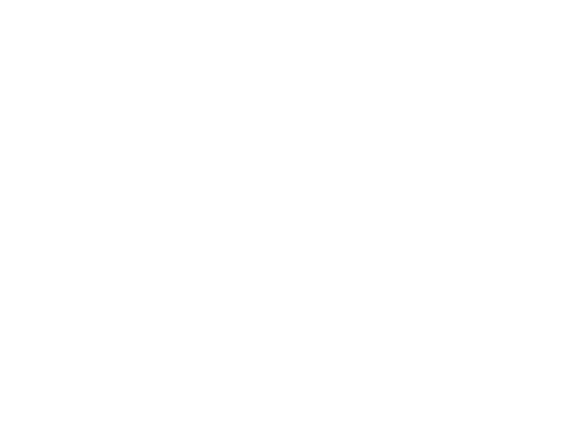

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [17]:
display_toggle_image_stack([rois.multiply( rois.max(1).power(-1) ).sum(0).reshape(frame_height, frame_width) for rois in ROIs_aligned], clim=None)

In [18]:
def display_toggle_2channel_image_stack(images, clim=None):
    from ipywidgets import interact, widgets

    fig, axs = plt.subplots(1,2 , figsize=(14,8))
    ax_1 = axs[0].imshow(images[0][...,0], clim=clim)
    ax_2 = axs[1].imshow(images[0][...,1], clim=clim)

    def update(i_frame = 0):
        fig.canvas.draw_idle()
        ax_1.set_data(images[i_frame][...,0])
        ax_2.set_data(images[i_frame][...,1])


    interact(update, i_frame=widgets.IntSlider(min=0, max=len(images)-1, step=1, value=0));

<IPython.core.display.Javascript object>


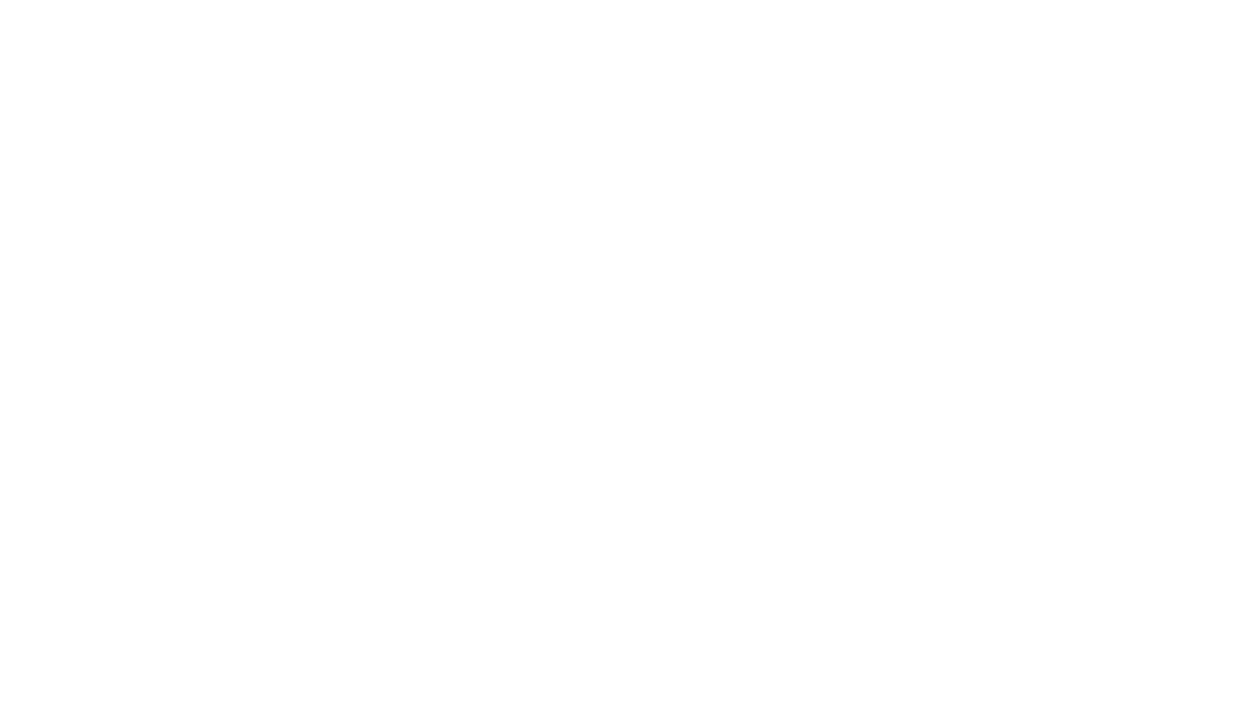

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [19]:
display_toggle_2channel_image_stack(flows, clim=(-4,4))

### Blur ROIs (optional)

In [20]:
def pydata_sparse_to_spconv(sp_array, device='cpu'):
    coo = sparse.COO(sp_array)
    idx_raw = torch.as_tensor(coo.coords.T, dtype=torch.int32, device=device).contiguous()
    spconv_array = spconv.SparseConvTensor(
        features=torch.as_tensor(coo.reshape((-1)).T.data, dtype=torch.float32, device=device)[:,None].contiguous(),
        indices=idx_raw,
        spatial_shape=coo.shape[1:], 
        batch_size=coo.shape[0]
    )
    return spconv_array

def sparse_convert_spconv_to_scipy(sp_arr):
    coo = sparse.COO(
        coords=sp_arr.indices.T.to('cpu'),
        data=sp_arr.features.squeeze().to('cpu'),
        shape=[sp_arr.batch_size] + sp_arr.spatial_shape
    )
    return coo.reshape((coo.shape[0], -1)).to_scipy_sparse().tocsr()
    

def sparse_conv2D(images, kernel, image_shape, device='cpu'):
    """
    images: scipy.sparse.csr_matrix. Flattened images.
        an individual image should be reconstructable by:
         images[ii].toarray().reshape(image_shape[0], image_shape[1])
    kernel: 2d array
    """
    
    ## prepare images
    images_spconv = pydata_sparse_to_spconv(
        sparse.COO(images).reshape((images.shape[0], image_shape[0], image_shape[1])),
        device=device
    )
    
    ## prepare kernel
    kernel_prep = torch.as_tensor(
        kernel[:,:,None,None], 
        dtype=torch.float32,
        device=device
    ).contiguous()
    
    ## prepare convolution
    conv = spconv.SparseConv2d(
        in_channels=1, 
        out_channels=1,
        kernel_size=kernel.shape, 
        stride=1, 
        padding=kernel.shape[0]//2, 
        dilation=1, 
        groups=1, 
        bias=False
    )
    
    conv.weight = torch.nn.Parameter(data=kernel_prep, requires_grad=False)
    
    images_conv = conv(images_spconv)
    return sparse_convert_spconv_to_scipy(images_conv)

def give_sparse_len(sparse_matrix):
    class obj_give_sparse_len:
#     class obj_give_sparse_len(type(sparse_matrix)):
        def __init__(self, sparse_matrix):
#             super().__init__(sparse_matrix)
            self.sp_matrix = sparse_matrix

        def __len__(self):
            return self.sp_matrix.shape[0]
        
        def __getitem__(self, idx):
            return self.sp_matrix[idx]
    
    return obj_give_sparse_len(sparse_matrix)

def batch_2D_sparse_convolution(images, kernel, image_shape, batch_size=None, num_batches=100, device='cpu'):
    images_w_len = give_sparse_len(images)
    
    return scipy.sparse.vstack([sparse_conv2D(
        images=batch, 
        kernel=kernel,
        image_shape=image_shape,
        device=device
    ) for batch in indexing.make_batches(images_w_len, batch_size=batch_size, num_batches=num_batches)])

<IPython.core.display.Javascript object>


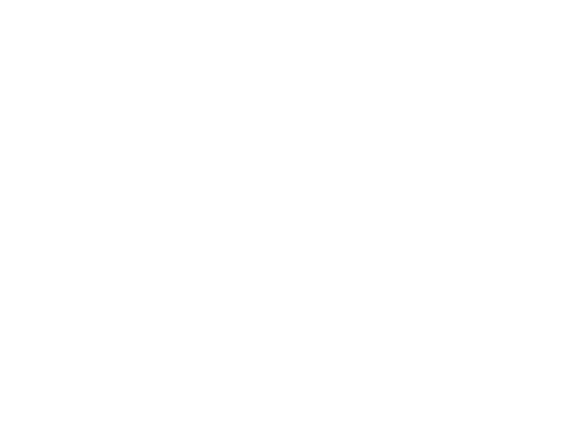

  0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
## only needed if convolving ROIs and/or using neural net outputs for distance matrix
pref_blurROIs = True
DEVICE_blur = 'cuda' # define torch device to use. either 'cpu', 'cuda', number, or something else. See torch_helpers.set_device()
pref_lowMem = False # if you are on a low memory computer, then select True. Convolution will be slower.

if pref_blurROIs == True:
    import torch
    import spconv.pytorch as spconv
    
    kernel_size = 7 # Edge length of kernel image. Make odd number.
    kernel_sigma = 1 # sigma of 2D gaussian kernel
    kernel = featurization.gaussian_kernel_2D(center=(kernel_size//2, kernel_size//2), image_size=(kernel_size, kernel_size), sig=kernel_sigma)
    kernel = kernel / kernel.sum()

    ## show the kernel
    plt.figure()
    plt.imshow(kernel);
    plt.title('gaussian kernel')
    
    ROIs_aligned_blur = [batch_2D_sparse_convolution(
        images=rois, 
        kernel=kernel,
        image_shape=(frame_height, frame_width),
        num_batches=10,
        device=DEVICE_blur,
    ) for rois in tqdm(ROIs_aligned)]

<IPython.core.display.Javascript object>


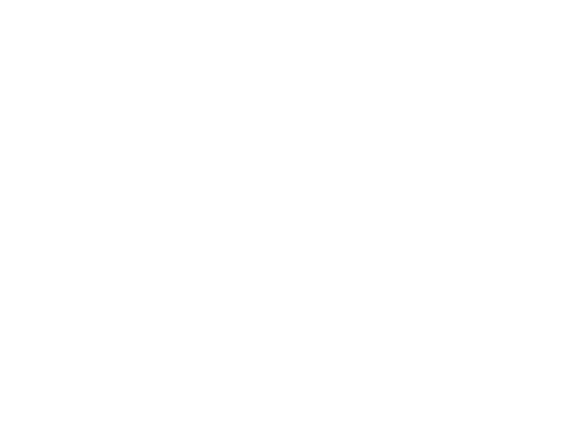

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [22]:
display_toggle_image_stack([ROIs.sum(0).reshape(frame_height, frame_width) for ROIs in ROIs_aligned_blur])

### Neural network embedding distances

In [23]:
pref_use_NN_distances = True

if pref_use_NN_distances == True:
    import torch

In [24]:
## NN fileNames
fileName_NN_pth = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient.pth' # name of pth file in dir_NNmodels directory
fileName_NN_py  = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient' # EXCLUDE THE .PY AT THE END. name of py file in dir_NNmodels directory.
# fileName_classifier = 'logreg_model_0.01.pkl' # path to logististic classifier pickle file in dir_classifiers

## Directories of Classifier stuff
dir_GRC_repo = dir_github / 'GCaMP_ROI_classifier'
dir_GRC_EndUser = dir_GRC_repo / 'End_User'
dir_NNmodels = dir_GRC_EndUser / 'simclr-models'
dir_GRC_util = dir_GRC_repo / 'new_stuff'

## Paths to NN and LR classifiers
path_NN_pth = dir_NNmodels / fileName_NN_pth
path_NN_py = dir_NNmodels / fileName_NN_py

In [25]:
import sys
sys.path.append(str(dir_NNmodels))
sys.path.append(str(dir_github))
sys.path.append(str(dir_GRC_util))
sys.path.append(str(dir_GRC_EndUser))

%load_ext autoreload
%autoreload 2
import util
import simclr_helpers
from basic_neural_processing_modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
sf_all_cropped = util.import_multiple_stat_files(
    paths_statFiles=paths_allStat, 
#     dir_statFiles=None,
#     fileNames_statFiles=None,
    out_height_width=[36,36], 
    max_footprint_width=441, 
    plot_pref=False
)

In [27]:
device_model = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [28]:
def import_pth_model(path_pth, path_py):
    # Instantiate Model
    import importlib
    model_module = importlib.import_module(fileName_NN_py)
    model = model_module.get_model(path_NN_pth)
    model.eval();
    return model, model_module

In [29]:
model, model_module = import_pth_model(path_NN_pth, fileName_NN_py)

In [30]:
data = np.concatenate(sf_all_cropped, axis=0)

# Create Data Sets / Data Loaders
dataset, dataloader = model_module.get_dataset_dataloader(data, batch_size=64, device=device_model) ## TODO: Troubleshoot the runtime on this

In [31]:
# Get Model Latents
latents = simclr_helpers.dataloader_to_latents(dataloader, model.to(device_model), DEVICE=device_model)

  0%|          | 0/153 [00:00<?, ?it/s]

In [32]:
from kymatio.torch import Scattering2D

In [33]:
scattering = Scattering2D(J=2, L=8, shape=sf_all_cropped[0].shape[-2:])
if device_model != 'cpu':
    scattering = scattering.cuda()

In [34]:
def get_latents_swt(sfs, swt):
    sfs = torch.as_tensor(np.ascontiguousarray(sfs[None,...]), device=device_model, dtype=torch.float32)
    latents_swt = swt(sfs[None,...]).squeeze()
    latents_swt = latents_swt.reshape(latents_swt.shape[0], -1)
    return latents_swt

In [35]:
latents_swt = torch.cat([get_latents_swt(sfs, scattering.cuda()).cpu() for sfs in sf_all_cropped], axis=0)

Get number of ROIs per FOV. Will be useful later for indexing stuff

In [36]:
n_roi_per_sesh = [sfs.shape[0] for sfs in ROIs_aligned]

n_roi_all = np.sum(n_roi_per_sesh)

Normalize

In [37]:
def make_block_batches(
    frame_height=512,
    frame_width=1024,
    block_height=100,
    block_width=100,
    overlapping_width_Multiplier=2,
    outer_block_height=None,
    outer_block_width=None,
    clamp_outer_block_to_frame=True,
):     
    
    # block prep
    block_height_half = block_height//2
    block_width_half = block_width//2
    
    # inner block prep
    if outer_block_height is None:
        outer_block_height = block_height * 1.5
        print(f'Outer block height not specified. Using {outer_block_height}')
    if outer_block_width is None:
        outer_block_width = block_width * 1.5
        print(f'Outer block width not specified. Using {outer_block_width}')
        
    outer_block_height_half = outer_block_height//2
    outer_block_width_half = outer_block_width//2
    
    # find centers of blocks
#     n_blocks_x = np.ceil((frame_width*overlapping_width_Multiplier) / block_width).astype(np.int64)
    n_blocks_x = np.ceil(frame_width / (block_width - (block_width*overlapping_width_Multiplier))).astype(np.int64)

    centers_x = np.linspace(
        start=block_width_half,
        stop=frame_width - block_width_half,
        num=n_blocks_x,
        endpoint=True
    )

#     n_blocks_y = frame_height / block_height
    n_blocks_y = np.ceil(frame_height / (block_height - (block_height*overlapping_width_Multiplier))).astype(np.int64)
#     n_blocks_y = np.ceil(n_blocks_y*overlapping_width_Multiplier).astype(np.int64)
    centers_y = np.linspace(
        start=block_height_half,
        stop=frame_height - block_height_half,
        num=n_blocks_y,
        endpoint=True
    )
    
#     print(n_blocks_x)
#     print(centers_x)
    
    # make blocks
    blocks, outer_blocks = [], []
    for i_x in range(n_blocks_x):
        for i_y in range(n_blocks_y):
            blocks.append([
                list(np.int64([centers_y[i_y] - block_height_half , centers_y[i_y] + block_height_half])),
                list(np.int64([centers_x[i_x] - block_width_half , centers_x[i_x] + block_width_half]))
            ])
            
            outer_blocks.append([
                list(np.int64([centers_y[i_y] - outer_block_height_half , centers_y[i_y] + outer_block_height_half])),
                list(np.int64([centers_x[i_x] - outer_block_width_half , centers_x[i_x] + outer_block_width_half]))                
            ])
            
    # clamp outer block to limits of frame
    if clamp_outer_block_to_frame:
        for ii, outer_block in enumerate(outer_blocks):
            br_h = np.array(outer_block[0]) # block range height
            br_w = np.array(outer_block[1]) # block range width
            valid_h = (br_h>0) * (br_h<frame_height)
            valid_w = (br_w>0) * (br_w<frame_width)
            outer_blocks[ii] = [
                list( (br_h * valid_h) + (np.array([0, frame_height])*np.logical_not(valid_h)) ),
                list( (br_w * valid_w) + (np.array([0, frame_width])*np.logical_not(valid_w)) ),            
            ]
        
    return blocks, outer_blocks, (centers_y, centers_x)

set parameters

In [38]:
frame_height=FOVs_aligned[0].shape[0]
frame_width=FOVs_aligned[0].shape[1]
block_height=100
block_width=100
overlapping_width_Multiplier=0.0
outer_block_height=150
outer_block_width=150
clamp_outer_block_to_frame=True

inner_blocks, outer_blocks, centers = make_block_batches(
    frame_height=frame_height,
    frame_width=frame_width,
    block_height=block_height,
    block_width=block_width,
    overlapping_width_Multiplier=overlapping_width_Multiplier,
    outer_block_height=outer_block_height,
    outer_block_width=outer_block_width,
    clamp_outer_block_to_frame=clamp_outer_block_to_frame
)
n_blocks = len(inner_blocks)
# display(inner_blocks)
# display(outer_blocks)
print(n_blocks)

66


visualize blocks

In [39]:
def visualize_blocks(inner_blocks, outer_blocks, frame_height=512, frame_width=1024):
    im = np.zeros((frame_height, frame_width, 3))
    for block in inner_blocks:
        im[block[0][0]:block[0][1], block[1][0]:block[1][1], 0] += 0.2
    for block in outer_blocks:
        im[block[0][0]:block[0][1], block[1][0]:block[1][1], 1] += 0.2
    plt.figure()
    plt.imshow(im)

<IPython.core.display.Javascript object>


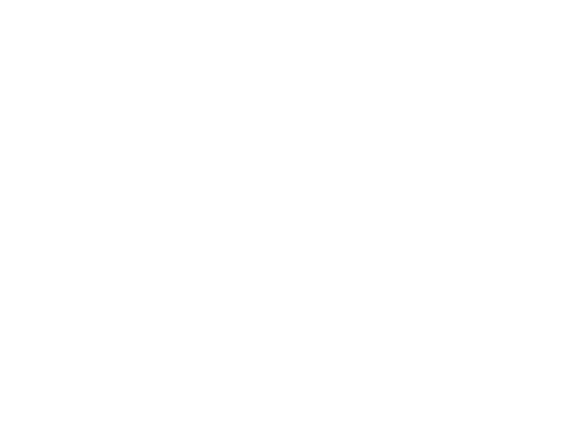

In [40]:
visualize_blocks(inner_blocks, outer_blocks, frame_height=512, frame_width=1024)

Main code block: \
computes matches across sessions for each block

In [41]:
######## CPU PARAMETERS ########
##### Ignore if using GPU ######
################################

NN_cpu = sklearn.neighbors.NearestNeighbors(
#         n_neighbors=100,  ## currently using min(sf_block_flat.shape[0], max_n_neighbors)
#     radius=1.0, 
    algorithm='auto',
    leaf_size=30, 
    metric='manhattan',
    p=1,
#     metric_params=None, 
    n_jobs=-1
)

tsne_cpu = sklearn.manifold.TSNE(
    n_components=2,
#     perplexity=30.0,
    early_exaggeration=12.0,
    learning_rate='auto',
#     learning_rate=,
    n_iter=1000,
    n_iter_without_progress=300,
    min_grad_norm=1e-07,
    metric='precomputed',
    init='random',
    verbose=0,
    random_state=None,
    method='barnes_hut',
#     method='exact',
    angle=0.8,
    n_jobs=-1,
#     square_distances=True,
)

In [42]:
#### IMPORTANT PARAMETER: K-NEAREST NEIGHBORS ####
## Lower this to improve speed, but sacrifice some quality. 
## Choose a number that is > ~ the largest number of ROIs you think a single ROI might have any overlap with.
## For most datasets, values around 200 should give high quality results.
## Max value is 1023.
## Value must be > 3*perplexity.

max_n_neighbors = 100
max_perplexity = 10

##################################################


####### Other Parameters #######

## This parameter determines how 'binary'-looking masks are
## Small values = more binary. Large values weight bright pixels more
## mask_scaled = mask ** mask_power
mask_power = 0.3



pref_use_GPU = False

if pref_use_GPU:
    NN = NN_gpu
    tsne = tsne_gpu
else:
    NN = NN_cpu
    tsne = tsne_cpu

In [43]:
def make_session_similarity_matrix(idx_sessions, d_diff=1, d_same=0):
    arr = np.zeros((len(idx_sessions), len(idx_sessions)), dtype=np.int16)
    arr = np.zeros((len(idx_sessions), len(idx_sessions)), dtype=np.bool8)
    for ii in range(idx_sessions.max().astype(np.int64) + 1):
        arr += (idx_sessions==ii)[:,None] @ (idx_sessions==ii)[None,:]

    return arr*(d_same - d_diff) + d_diff
#     return arr

In [44]:
idx_roi_cat = np.concatenate([np.arange(sfs.shape[0]) for sfs in ROIs_aligned]) # indices of each ROI concatenated together
idx_roi_session = np.concatenate([np.ones(sfs.shape[0])*ii for ii,sfs in enumerate(ROIs_aligned)])

if pref_blurROIs:
# if False:
    ROIs_toUse = ROIs_aligned_blur
else:
    ROIs_toUse = ROIs_aligned

block_rois = []
for i_block in tqdm(range(n_blocks)):
# for i_block in tqdm([2]):
    ## Get indices of ROIs in outer and inner blocks
    def get_ROI_idx_from_block_idx(block, spatial_footprints_flat, frame_height=frame_height, frame_width=frame_width):
        """
        This function:
         1. gets the indices of all the pixels in the block (return: idx_block)
         2. crops each spatial footprint image (size frame_height x frame_width) to just 
            the block pixels (return: sf_block_allSesh)
         3. finds the ROIs that are within the block and makes boolean and index output arrays listing them.
            Outputs:
             a. bool_ROI_inBlock_allSesh: a list where each entry is a session and each element is a boolean
                array listing whether that ROI is in the block
             b. idx_ROI_inBlock_allSesh: a list where each entry is a session and each element is the index
                of an ROI that is in the block
             c. boolCat_ROI_inBlock: an array listing which ROIs across all sessions that are in the block
             d. idxCat_ROI_inBlock: an array listing the indices of ROIs across all sessions that are in 
                the block
        """
        idx_block = np.reshape(
            np.ravel_multi_index(
                np.meshgrid(np.arange(block[0][0], block[0][1]), np.arange(block[1][0], block[1][1])),
                (frame_height, frame_width),
                order='C'),
            newshape=-1,
            order='F')

        sf_block_allSesh         = [sfs[:,idx_block] for sfs in spatial_footprints_flat]
        bool_ROI_inBlock_allSesh = [np.array(sfs.sum(1) > 0).squeeze() for sfs in sf_block_allSesh]
        idx_ROI_inBlock_allSesh  = [np.where(bool_ROI)[0] for bool_ROI in bool_ROI_inBlock_allSesh]

        boolCat_ROI_inBlock = np.concatenate(bool_ROI_inBlock_allSesh)
        idxCat_ROI_inBlock = np.where(boolCat_ROI_inBlock)[0]
        
        return idx_block, bool_ROI_inBlock_allSesh, idx_ROI_inBlock_allSesh, boolCat_ROI_inBlock, idxCat_ROI_inBlock, sf_block_allSesh
    
    idx_outer_block, bool_ROI_inOuterBlock_allSesh, idx_ROI_inOuterBlock_allSesh, boolCat_ROI_inOuterBlock, idxCat_ROI_inOuterBlock, sf_OuterBlock_allSesh = \
        get_ROI_idx_from_block_idx(
            block=outer_blocks[i_block], 
            spatial_footprints_flat=ROIs_toUse, 
            frame_height=frame_height, 
            frame_width=frame_width
        )
        
    idx_inner_block, bool_ROI_inInnerBlock_allSesh, idx_ROI_inInnerBlock_allSesh, boolCat_ROI_inInnerBlock, idxCat_ROI_inInnerBlock, sf_InnerBlock_allSesh = \
        get_ROI_idx_from_block_idx(
            block=outer_blocks[i_block], 
            spatial_footprints_flat=ROIs_toUse, 
            frame_height=frame_height, 
            frame_width=frame_width
        )

    
    sf_block_inROIs_allSesh      = [sfs[idx_ROI_inOuterBlock_allSesh[ii],:] for ii,sfs in enumerate(sf_OuterBlock_allSesh)]
    sf_block_flat        = scipy.sparse.vstack([sfs for sfs in sf_block_inROIs_allSesh])
    sf_block_flat_scaled = sf_block_flat.power(mask_power)
    sf_block_flat_scaled = sf_block_flat_scaled.multiply( 0.5 / sf_block_flat_scaled.sum(1)) # this scaling makes each ROI sum to 0.5, so the max distance between two ROIs is 1
    sf_block_flat_scaled = scipy.sparse.csr_matrix(sf_block_flat_scaled)
    
    n_neighbors = min(sf_block_flat_scaled.shape[0]-1, max_n_neighbors)
#     print(f'Using n_neighbors: {n_neighbors}')

    distances_IOU = sklearn.neighbors.NearestNeighbors(
        algorithm='auto',
        leaf_size=30, 
        metric='manhattan',
        p=1,
    #     metric_params=None, 
        n_jobs=-1
    ).fit(sf_block_flat_scaled).kneighbors_graph(
        sf_block_flat_scaled,
        n_neighbors=n_neighbors,
        mode='distance'
    )

#     distances_IOU[distances_IOU>0.99] = distances_IOU[distances_IOU>0.99]*100


    if pref_use_NN_distances:
#     if False:
        ltu = latents[idxCat_ROI_inOuterBlock]
        ltu = 1*(ltu / torch.sum(ltu, dim=1, keepdim=True))
        dist_latents_NN = torch.cdist(ltu, ltu, p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary').numpy()

        ltu = latents_swt[idxCat_ROI_inOuterBlock]
        ltu = 1*(ltu / torch.sum(ltu, dim=1, keepdim=True))
        dist_latents_swt = torch.cdist(ltu, ltu, p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary').numpy()
        
        dist_latents = dist_latents_NN * dist_latents_swt
#         dist_latents = dist_latents_NN 
        
#         ltu = latents_swt[idxCat_ROI_inOuterBlock]
#         ltu = 0.7071067811865476*(ltu / torch.sum(ltu, dim=1, keepdim=True))
#         cc_latents = np.corrcoef(ltu)
#         cc_latents[cc_latents<0] = 0
#         dist_latents = ((0+1) / (cc_latents**2)) -1
#         dist_latents = sim2dist(cc_latents,1,1)

        r = distances_IOU.tocoo().row
        c = distances_IOU.tocoo().col
        dist_latents_sparse = scipy.sparse.csr_matrix((dist_latents[r,c], (r,c)), shape=dist_latents.shape)

        distances_toUse = distances_IOU.power(1).multiply(dist_latents_sparse.power(1))
    else:
        distances_toUse = distances_IOU.power(1)
    
    
    distances_sessions = make_session_similarity_matrix(idx_roi_session[boolCat_ROI_inOuterBlock], d_diff=0, d_same=1)
    distances_sessions = distances_sessions * np.logical_not(np.eye(distances_sessions.shape[0]))
    r = distances_IOU.tocoo().row
    c = distances_IOU.tocoo().col
    distances_sessions_sparse = scipy.sparse.csr_matrix((distances_sessions[r,c], (r,c)), shape=distances_sessions.shape)

    
    distances_toUse[distances_IOU>1] = 1
    distances_toUse[distances_sessions_sparse.astype(np.bool8)] = 1
#     distances_toUse[distances_toUse>0.99] = 2
    
    tsne.n_neighbors = n_neighbors
    tsne.perplexity = min(max_perplexity, distances_toUse.shape[0]//4)
    print(tsne.perplexity)
#     if pref_use_GPU:
#         embeddings = tsne.fit_transform(
#             X=sf_block_flat_scaled,
#             knn_graph=distances_toUse
#         )
#     else:
    embeddings = tsne.fit_transform(
        X=distances_toUse,
#             X=distances_toUse.toarray(),
    )


    block_rois.append({

        "idx_outer_block": idx_outer_block,
        "idx_inner_block": idx_inner_block,
        
        "bool_ROI_inOuterBlock_allSesh": bool_ROI_inOuterBlock_allSesh, # shape: (list len n_blocks (n_roi per block)). value: whether that roi is in the outer block
        "idx_ROI_inOuterBlock_allSesh" :  idx_ROI_inOuterBlock_allSesh, # shape: (list len n_blocks (n_roi in outer block)). value: indices of rois in the outer block
        "boolCat_ROI_inOuterBlock": boolCat_ROI_inOuterBlock, # shape: (n_roi across sessions). value: whether that roi is in the outer block
        "idxCat_ROI_inOuterBlock": idxCat_ROI_inOuterBlock, # shape: (n_roi in the outer block across all sessions). value: indices of the rois in the outer block
        
        "bool_ROI_inInnerBlock_allSesh": bool_ROI_inInnerBlock_allSesh, # shape: (list len n_blocks (n_roi per block)). value: whether that roi is in the inner block
        "idx_ROI_inInnerBlock_allSesh" :  idx_ROI_inInnerBlock_allSesh, # shape: (list len n_blocks (n_roi in inner block)). value: indices of rois in the inner block
        "boolCat_ROI_inInnerBlock": boolCat_ROI_inInnerBlock, # shape: (n_roi across sessions). value: whether that roi is in the inner block
        "idxCat_ROI_inInnerBlock": idxCat_ROI_inInnerBlock, # shape: (n_roi in the inner block across all sessions). value: indices of the rois in the inner block
        
        "n_neighbors": n_neighbors,
        "distances": distances_toUse,
        "tsne": tsne,
        "embeddings": embeddings,
    })

  0%|          | 0/66 [00:00<?, ?it/s]

10


C:\Users\Rich Hakim\.conda\envs\BMI_IDAP\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
C:\Users\Rich Hakim\.conda\envs\BMI_IDAP\lib\site-packages\sklearn\neighbors\_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


<IPython.core.display.Javascript object>


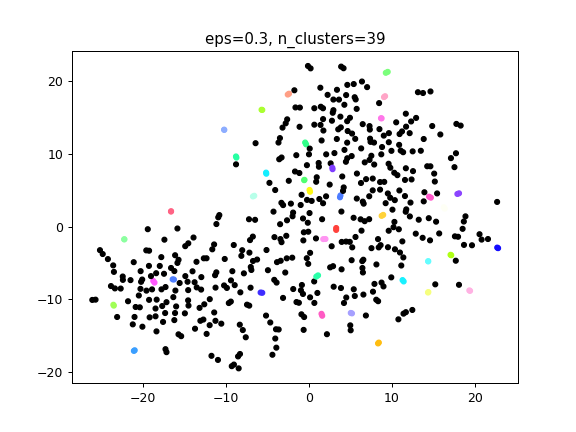

interactive(children=(IntSlider(value=100, description='eps', max=400, min=1), Output()), _dom_classes=('widge…

In [52]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

block_toUse = 10
min_samples = 2
max_samples = 2 # for use within this cell only (visualization and titrating eps value). Set to None to speed up visualization

# db = block_rois[block_toUse]['db']
embeddings = block_rois[block_toUse]['embeddings']
# embeddings = embeddings

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(embeddings[:,0], embeddings[:,1], s=15)
# sc = ax.scatter(embeddings2[:,0], embeddings2[:,1], embeddings2[:,2], s=15)

def get_val_counts(vals):
    vals_unique = np.unique(vals)
    vals_counts = np.zeros_like(vals, dtype=np.int64)
    for ii, val in enumerate(vals_unique):
        vals_counts[vals==val] = np.sum(vals==val)
    return vals_counts
def update(eps = 1.0):
    eps_toUse = (eps/200)**2
    # Compute DBSCAN
    db = sklearn.cluster.DBSCAN(
        eps=eps_toUse,
        min_samples=min_samples, 
#         metric='manhattan',
        metric_params=None, 
        algorithm='auto',
        leaf_size=30, 
        p=2, 
        n_jobs=-1
    ).fit(embeddings)
    
    labels = db.labels_
#     labels = db.labels_ - db.labels_.min()
    if max_samples is not None:
        labels[get_val_counts(labels) > max_samples] = -1
    
    cmap = plotting_helpers.rand_cmap(len(np.unique(labels)), verbose=False)
#     cmap = plotting_helpers.rand_cmap(2, verbose=False)
    
    if len(np.unique(labels)) == 1:
        print('Eps value gives one big cluster. Adjust')
    else:
        sc.set_color(cmap(classification.squeeze_integers(labels)))

        fig.canvas.draw_idle()
        ax.set_title(f'eps={round(eps_toUse,2)}, n_clusters={len(np.unique(labels))}')
        print(np.unique(labels))

interact(update, eps=widgets.IntSlider(min=1, max=400, step=1, value=100));

I have to make the blocks contain the same number of ROIs FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF

set parameters for clustering

In [53]:
# eps_values = np.arange(0.05, 0.3, 0.05)
eps_values = np.array([0.3])
min_samples = 2
dbscan_objs = [sklearn.cluster.DBSCAN(
        eps=eps,
        min_samples=min_samples, 
#         metric='manhattan',
        metric_params=None, 
        algorithm='auto',
        leaf_size=30, 
        p=2, 
        n_jobs=-1
    )
              for eps in eps_values]

In [54]:
def is_unique(vals):
    is_unique = len(vals) == len(np.unique(vals))
    return is_unique

In [55]:
block_rois2 = copy.deepcopy(block_rois)

In [58]:
block_rois = [copy.deepcopy(block) for block in block_rois2*len(dbscan_objs)] 

In [59]:
def freq_of_values(vals):
    u = np.unique(vals)
    f = np.array([np.sum(vals==unique) for unique in u])
    return np.array([f[u==val][0] for val in vals])

In [60]:
n_bse = n_blocks_single_eps = len(block_rois2)
for jj, dbscan in enumerate(tqdm(dbscan_objs)):
    for ii, block in enumerate(block_rois2):
#         print(ii, jj, jj*n_bse + ii, dbscan.eps)
        ## DBSCAN
        db = copy.deepcopy(dbscan)
        db.fit(block['embeddings']) # note that db.labels_==-1 means no cluster found
        db.labels_[freq_of_values(db.labels_) < min_samples] = -1 # fail safe because sometimes there are clusters of just 1 for some reason...

        block_rois[jj*n_bse + ii]['db'] = db
#         block_rois[jj*n_bse + ii]['test'] = db.eps
        block_rois[jj*n_bse + ii]['labels_unique'] = np.unique(db.labels_)
        block_rois[jj*n_bse + ii]['cluster_sessions'] = [idx_roi_session[block_rois[jj*n_bse + ii]['idxCat_ROI_inOuterBlock'][db.labels_==label]] for label in block_rois[jj*n_bse + ii]['labels_unique']] # list of sessions a unique label derives from. Shape: [n_unique_labels][num of sessions where label is found]
        block_rois[jj*n_bse + ii]['cluster_sessions_isUnique'] = np.array([is_unique(sessions) for sessions in block_rois[jj*n_bse + ii]['cluster_sessions']]) # boolean. Shape (n_labels_unique). Value whether all the labels derive from unique sessions.
        
#         print(block['embeddings'].shape)
#         print(block['idxCat_ROI_inOuterBlock'].shape)
#         print(block['db'].labels_.shape)
#         print(block['db'].eps)
#         print(db.labels_.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

In [61]:
# pickle_helpers.simple_save(block_rois, '/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/block_rois_valerio1_distal.pkl')

In [62]:
# block_rois = pickle_helpers.simple_load('/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/block_rois.pkl')

the following block should be able to get folded into the main loop above. Just need to break the list comprehension up into a real for loop and index into both the inner and outer blocks

In [63]:
bool_roi_outerBlock_cat = np.stack([block['boolCat_ROI_inOuterBlock'] for block in block_rois])
bool_roi_innerBlock_cat = np.stack([block['boolCat_ROI_inInnerBlock'] for block in block_rois])

In [64]:
# ## Process inner block (ROI idx ownership)
# idx_roi_inInnerBlock = []
# for ii, block in enumerate(tqdm(blocks)):
#     sf_block_cat = np.concatenate([sfs.toarray().reshape(sfs.shape[0], frame_height, frame_width)[:,block[0][0]:block[0][1], block[1][0]:block[1][1]] for sfs in ROIs_aligned], axis=0) # cropped spatial footprints. shape=(n_rois across all sessions, inner_block_height, inner_block_width)
#     idx_outOfInnerBlock = np.sum(sf_block_cat, axis=(1,2)) == 0 # roi idx bool that have no pixels in the current block
#     idx_roi_inInnerBlock.append(idx_outOfInnerBlock==False) # roi idx bool that have any pixels in the current block
    

## Get ROI properties
1. Cluster size (n_roi in cluster)
2. Cluster mean of distances (mean of differences between spatial footprints)
3. Cluster std of distances (variance of differences between spatial footprints)
4. Cluster max of distances (max of differences between spatial footprints)

Heuristic to determine which block to trust for each ROI:

- for each block, determine how many rois are a part of each cluster
- for each roi, determine how many 'neighbor' rois are in it's cluster


- then, for each roi, trust the block that clustered it with the greatest number of ROIs that wasn't too many (ranges between a user defined range)

### 1. Cluster size

Get sizes of each cluster

In [65]:
unique_cluster_ids = [block['labels_unique'] for block in block_rois]
sizes_clusters = [ [(block['db'].labels_==cid).sum() for cid in unique_cluster_ids[i_block]] for i_block, block in enumerate(block_rois) ]

### 2. Clusters from unique sessions

In [66]:
clusters_fromUniqueSessions = [block['cluster_sessions_isUnique'] for block in block_rois]

### 3-5. Distance statistics

User settings

In [67]:
######## CPU PARAMETERS ########
##### Ignore if using GPU ######
################################

NN_cpu = sklearn.neighbors.NearestNeighbors(
#         n_neighbors=100,  ## currently using min(sf_block_flat.shape[0], max_n_neighbors)
#     radius=1.0, 
    algorithm='auto',
    leaf_size=30, 
    metric='manhattan',
    p=1,
#     metric_params=None, 
    n_jobs=-1
)

In [68]:
pref_use_GPU = False

if pref_use_GPU:
    NN = NN_gpu
    tsne = tsne_gpu
else:
    NN = NN_cpu
    tsne = tsne_cpu

In [69]:
mask_power = mask_power

Calculate feature distances for ROIs within each cluster

change the distance metric here to include the NN distance and also make the score a real cluster score \
dunn and sillouette

In [70]:
ROIs_aligned_cat = scipy.sparse.vstack(ROIs_aligned)
ROIs_aligned_cat_scaled = ROIs_aligned_cat
ROIs_aligned_cat_scaled = ROIs_aligned_cat_scaled.power(mask_power)
ROIs_aligned_cat_scaled = ROIs_aligned_cat_scaled.multiply( 1 / ROIs_aligned_cat_scaled.sum(1) )
ROIs_aligned_cat_scaled = scipy.sparse.csr_matrix(ROIs_aligned_cat_scaled)

distances_clusters = [[]]*len(block_rois)
for i_block, block in enumerate(tqdm(block_rois)):
#     print(block['embeddings'].shape)
#     print(block['idxCat_ROI_inOuterBlock'].shape)
#     print(block['db'].labels_.shape)
        
    labels = block['db'].labels_
    uci = unique_cluster_ids[i_block]
    distances_clusters[i_block] = [[]]*len(uci)
    for i_cid, cid in enumerate(uci):
        roi_idx_cluster = np.where(labels == cid)[0]
        roi_idx = block['idxCat_ROI_inOuterBlock'][roi_idx_cluster]
        features = ROIs_aligned_cat_scaled[roi_idx]
        
        n_neighbors = features.shape[0]
        distances = NN.fit(features).kneighbors_graph(
            features,
            n_neighbors=n_neighbors,
            mode='distance'
        )
        distances_clusters[i_block][i_cid] = distances
              

  0%|          | 0/66 [00:00<?, ?it/s]

In [71]:
## Calculate statistics of distance matrices
fn_dist_mean = lambda x: np.mean(x[np.triu_indices(x.shape[0], k=1)])
fn_dist_std = lambda x: np.std(x[np.triu_indices(x.shape[0], k=1)])
fn_dist_max = lambda x: np.max(x[np.triu_indices(x.shape[0], k=1)])

dist_mean_all = [ [fn_dist_mean(distances_clusters[i_block][ii].toarray()) for ii in range(len(distances_clusters[i_block]))] for i_block in range(len(distances_clusters)) ]
dist_std_all  = [ [fn_dist_std(distances_clusters[i_block][ii].toarray())  for ii in range(len(distances_clusters[i_block]))] for i_block in range(len(distances_clusters)) ]
dist_max_all  = [ [fn_dist_max(distances_clusters[i_block][ii].toarray())  for ii in range(len(distances_clusters[i_block]))] for i_block in range(len(distances_clusters)) ]

Plots for distance metrics

<IPython.core.display.Javascript object>


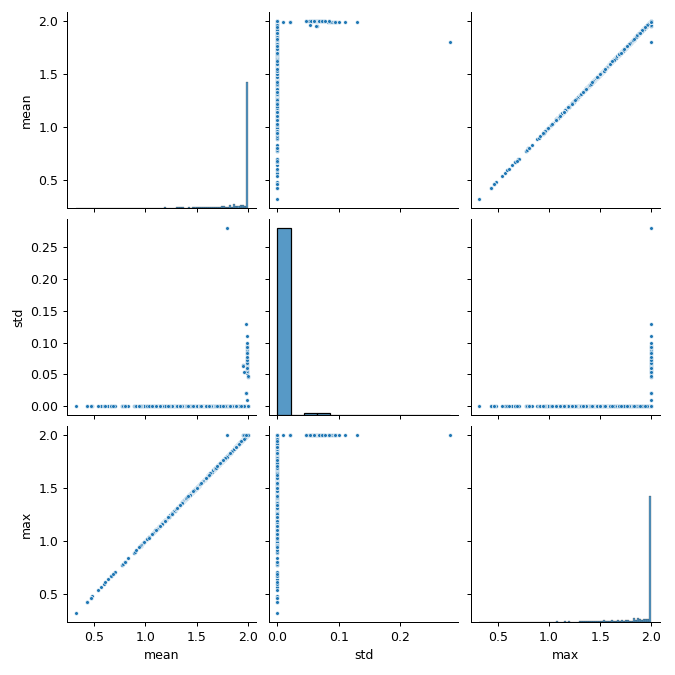

In [72]:
dist_mean_all_cat = np.concatenate(dist_mean_all)
dist_std_all_cat  = np.concatenate(dist_std_all)
dist_max_all_cat  = np.concatenate(dist_max_all)

pair_columns = pd.DataFrame({
    "mean": dist_mean_all_cat,
    "std": dist_std_all_cat,
    "max": dist_max_all_cat,
})
# plt.figure()
sns.pairplot(pair_columns, markers='.')

Set inclusion thresholds

In [73]:
cluster_properites = {
    "n_roi": sizes_clusters,
    "clusters_fromUniqueSessions": clusters_fromUniqueSessions,
    "cluster_distance_mean": dist_mean_all,
    "cluster_distance_std": dist_std_all,
    "cluster_distance_max": dist_std_all,
}

# cluster_inclusion_criteria_ranges = {
#     "n_roi": (8,8),
#     "clusters_fromUniqueSessions": (True,True),
#     "cluster_distance_mean": (0,0.8),
#     "cluster_distance_std": (0,0.3),
#     "cluster_distance_max": (0,1.3),
# }
cluster_inclusion_criteria_ranges = {
    "n_roi": (2,2),
    "clusters_fromUniqueSessions": (True,True),
    "cluster_distance_mean": (0,0.8),
    "cluster_distance_std": (0,0.7),
    "cluster_distance_max": (0,1.9),
}

Assign cluster scores by inner blocks to each ROI. \
output (roi_cluster_properties) is a dictionary. 1 entry for each property. entry shape: (n_blocks, n_roi)

In [74]:
n_blocks = len(block_rois)
n_properties = len(cluster_properites)

# roi_labelFreqs = np.ones((len(block_rois), n_roi_all)) * np.nan # shape (n_blocks, n_roi_total)
roi_cluster_properties = {key: np.ones((n_blocks, n_roi_all)) * np.nan for key,val in cluster_properites.items()}

for i_block, block in enumerate(tqdm(block_rois)):
    labels = block['db'].labels_
    labels_unique = np.unique(labels)
#     label_sizes = [list(labels).count(label) for label in labels_unique]
    
    bool_outer = block_rois[i_block]['boolCat_ROI_inOuterBlock']
    idx_outer  = block_rois[i_block]['idxCat_ROI_inOuterBlock']
    
    bool_inner = np.concatenate(block_rois[i_block]['bool_ROI_inInnerBlock_allSesh'])
    idx_inner = np.where(bool_inner)[0]
    
    for i_roi in range(n_roi_all): # for every ROI
        if i_roi in idx_outer: # check if roi was in the outer frame
            
            if i_roi in idx_inner: # check if roi was in the inner frame
                arg_outer = np.where(i_roi == idx_outer) # get argument in outer list of this roi
                label = labels[arg_outer] # get the label of this roi in this block
                arg_unique = np.where(labels_unique == label)[0][0] # get the idx/arg of of the labels_unique label
                
                
                for i_property, (key, val) in enumerate(cluster_properites.items()):
                    roi_cluster_properties[key][i_block, i_roi] = val[i_block][arg_unique]
#                     print(val[i_block][arg_unique])
#                     print(roi_cluster_properties[key][i_block, i_roi])
#                     roi_cluster_properties

  0%|          | 0/66 [00:00<?, ?it/s]

In [75]:
def bool_in_range(array, range_vals):
    return (array >= range_vals[0]) * (array <= range_vals[1])

In [76]:
roi_cluster_inclusion_allProperties = {key: bool_in_range(roi_cluster_properties[key], cluster_inclusion_criteria_ranges[key]) for key,val in roi_cluster_properties.items()}
roi_cluster_inclusion = np.stack(tuple(roi_cluster_inclusion_allProperties.values())).prod(0)

<IPython.core.display.Javascript object>


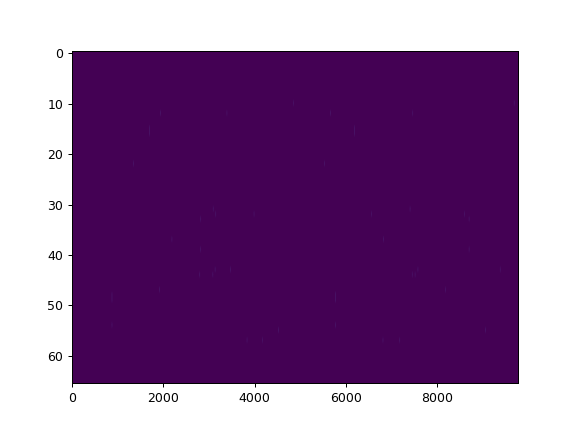

In [77]:
plt.figure()
plt.imshow(roi_cluster_inclusion, aspect='auto', interpolation='antialiased')

<IPython.core.display.Javascript object>


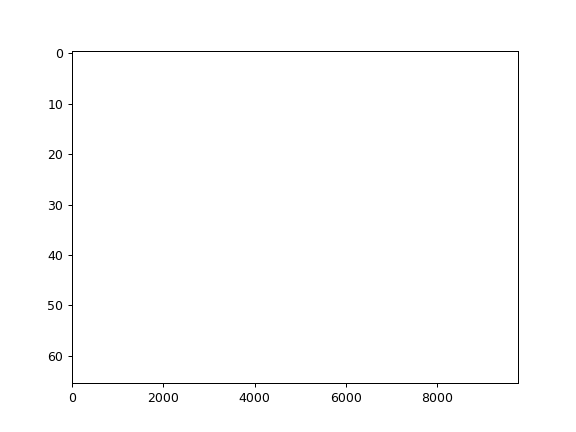

In [78]:
plt.figure()
plt.imshow(roi_cluster_properties['cluster_distance_mean'], aspect='auto', interpolation='antialiased')

- randomly choose rois from a list of all eligible ROIs
- randomly choose a block that meet criteria for that roi,
- find what other rois are a part of the cluster that it's in
    - find what it's cluster label is for that block
    - find other rois with that cluster label
- assign that roi and all of the rois in that cluster a UCID
- remove all those rois from the list to choose from

- change step 2 to be 'best block'

In [79]:
UCIDs_rough = np.ones(n_roi_all, dtype=np.int64) * -1
rois_included = np.where(roi_cluster_inclusion.sum(0) > 0)[0]
list_eligible = copy.copy(rois_included)
ucid_new = 0
bunch_of_nans = np.ones(len(UCIDs_rough))*np.nan
UCID_properties = {
    'block':                 copy.copy(bunch_of_nans),
    'idx_in_outerBlock':     copy.copy(bunch_of_nans),
    'label_in_outerBlock':   copy.copy(bunch_of_nans),
    "n_roi_in_Cluster":      copy.copy(bunch_of_nans),
    "cluster_distance_mean": copy.copy(bunch_of_nans),
    "cluster_distance_std":  copy.copy(bunch_of_nans),
    "cluster_distance_max":  copy.copy(bunch_of_nans),
    "session":               idx_roi_session,
}
while len(list_eligible) > 0: # while there are still values that have not been deleted
    idx_inList = random.choice(list_eligible)
#     idx_inList = list_eligible[0]
    block_toUse = random.choice(np.where(roi_cluster_inclusion[:,idx_inList] > 0)[0])
    idx_in_block = np.where(block_rois[block_toUse]['idxCat_ROI_inOuterBlock'] == idx_inList)[0]
    label = block_rois[block_toUse]['db'].labels_[idx_in_block]
    idx_others_in_block = np.where(block_rois[block_toUse]['db'].labels_ == label)[0]
    idx_others = block_rois[block_toUse]['idxCat_ROI_inOuterBlock'][idx_others_in_block]
    
    if np.sum(np.isin(idx_others, np.where(UCIDs_rough>=0)[0]) > 0):
        list_eligible = np.delete(list_eligible, np.where(np.isin(list_eligible, idx_inList))[0])
        continue
    
    UCIDs_rough[idx_others] = ucid_new
    ucid_new += 1
    
    list_eligible = np.delete(list_eligible, np.where(np.isin(list_eligible, idx_others))[0])
    
    
    UCID_properties['block'][idx_others] = block_toUse
    UCID_properties['idx_in_outerBlock'][idx_others] = idx_others_in_block
    UCID_properties['label_in_outerBlock'][idx_others] = label
    UCID_properties['n_roi_in_Cluster'][idx_others] = roi_cluster_properties['n_roi'][block_toUse][idx_others]
    UCID_properties['cluster_distance_mean'][idx_others] = roi_cluster_properties['cluster_distance_mean'][block_toUse][idx_others]
    UCID_properties['cluster_distance_std'][idx_others] = roi_cluster_properties['cluster_distance_std'][block_toUse][idx_others]
    UCID_properties['cluster_distance_max'][idx_others] = roi_cluster_properties['cluster_distance_max'][block_toUse][idx_others]

In [80]:
UCIDs = UCIDs_rough

<IPython.core.display.Javascript object>


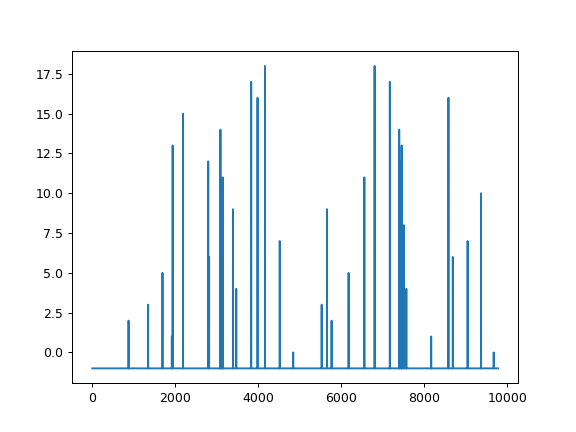

In [81]:
plt.figure()
plt.plot(UCIDs_rough)

In [88]:
def values_with_counts_outside_of_range(values, val_range, verbose=True):
    unique_values = np.unique(values)
    unique_counts = np.array([np.sum(values==val) for val in unique_values])
    bad_outOfRange = unique_values[
        np.logical_not(np.isin(
            unique_counts,
                np.arange(val_range[0], val_range[1]+1)
        ))
    ]
    print(f'Found bad values: {bad_outOfRange}')
    return bad_outOfRange

In [89]:
print(f'number of unique clusters: {len(np.unique(UCIDs_rough))}')

number of unique clusters: 20


In [90]:
bad_UCIDs = values_with_counts_outside_of_range(UCIDs_rough, cluster_inclusion_criteria_ranges['n_roi'])
UCIDs = copy.copy(UCIDs_rough)
UCIDs[np.isin(UCIDs, bad_UCIDs)] = -1
UCIDs = classification.squeeze_integers(UCIDs)
UCID_properties['UCID'] = UCIDs
values_with_counts_outside_of_range(UCIDs, cluster_inclusion_criteria_ranges['n_roi']);

Found bad values: [-1]
Found bad values: [-1]


In [91]:
unique_UCIDs = np.unique(UCIDs)

In [92]:
n_sessions = len(ROIs_aligned)
n_roi_per_sesh
bounds_idx_roi_per_sesh = np.concatenate([[0], np.cumsum(n_roi_per_sesh)])
UCIDs_bySession = [UCIDs[bounds_idx_roi_per_sesh[ii]:bounds_idx_roi_per_sesh[ii+1]] for ii in range(n_sessions)]

In [93]:
# make a UCID x session matrix (boolean)
UCIDs_inSession = np.array([np.isin(unique_UCIDs, UCIDs_bySession[i_sesh]) for i_sesh in range(n_sessions)])
if np.sum(UCIDs_inSession==0):
    print(f'WARNING: Make sure you are okay with the fact that there are sessions where clusters are not present')
if np.sum(UCIDs_inSession>1):
    print(f'WARNING: Make sure you are okay with the fact that there are sessions where a single cluster has more than ROI in it')

# Colored clusters image
make an animation loop of an entire FOV looping through each session with all the ROIs. \
Each ROI in a cluster is given a distinct cluster color

In [94]:
print('Available properties to use as colormap:')
display(list(UCID_properties.keys()))

Available properties to use as colormap:


['block',
 'idx_in_outerBlock',
 'label_in_outerBlock',
 'n_roi_in_Cluster',
 'cluster_distance_mean',
 'cluster_distance_std',
 'cluster_distance_max',
 'session',
 'UCID']

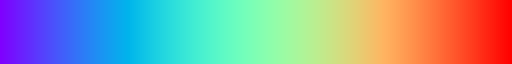

In [95]:
plt.get_cmap('rainbow')

Number of labels: 66


<IPython.core.display.Javascript object>


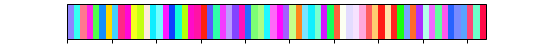

In [96]:
cmap = plotting_helpers.rand_cmap(66, type='bright', first_color_black=False)

In [99]:
ucid_toUse = unique_UCIDs[unique_UCIDs>0]
cmap_property = 'UCID'

vals_property = UCID_properties[cmap_property]
vals_property_ranged = timeSeries.scale_between(vals_property, lower=0, upper=1.1, verbose=False)


# cmaps = np.array([plt.get_cmap('Set3')(ii) for ii in vals_property_ranged])[:,:3]
cmaps = np.array([cmap(ii) for ii in vals_property_ranged])[:,:3]

FOV_all = []
chunk_size = np.array([3, n_sessions, frame_height, frame_width]).prod()
ROIs_csr = scipy.sparse.csr_matrix(scipy.sparse.vstack(ROIs_aligned))
for ii, ucid in enumerate(tqdm(ucid_toUse)):
   
    idx_roi_ucid = np.where(UCIDs == ucid)[0]
    colors = cmaps[idx_roi_ucid]
    
    n_ucid = len(idx_roi_ucid)
    ROIs_scaled = ROIs_csr[idx_roi_ucid].multiply( 1 / ROIs_csr[idx_roi_ucid].max())
    im_FOV_flat_tiled_color = scipy.sparse.vstack([ROIs_scaled.multiply(cmaps[idx_roi_ucid, i_color][:,None]) for i_color in range(3)])
#     im_FOV_flat = ROIs_csr[idx_roi_ucid]
#     im_FOV_flat = scipy.sparse.csr_matrix(scipy.sparse.vstack([ROIs_csr[ii] for ii in idx_roi_ucid]))
#     im_FOV_flat_scaled = im_FOV_flat_tiled_color.multiply(1 / im_FOV_flat_tiled_color.max(1).toarray())
    im_FOV_vector = im_FOV_flat_tiled_color.reshape((1,-1))
#     im_FOV_flat_scaled_tiled_color = scipy.sparse.vstack([im_FOV_flat_scaled.multiply(colors[ii]) for ii in range(3)]).reshape((1, -1))
#     im_FOV_flat_scaled_tiled_color = scipy.sparse.vstack([im_FOV_flat_scaled for ii in range(3)]).reshape((1, -1))

    FOV_all.append(im_FOV_vector)

FOV_all_sparseCOO = sparse.COO(scipy.sparse.vstack(FOV_all)).reshape((len(ucid_toUse), 3, n_sessions, frame_height, frame_width))

FOV_all_sparseCOO_flat = FOV_all_sparseCOO.sum(0).transpose((1,2,3,0))

FOV_all = FOV_all_sparseCOO_flat.todense()

  0%|          | 0/18 [00:00<?, ?it/s]

In [100]:
FOV_all_noClip = copy.copy(FOV_all)
FOV_all_noClip[FOV_all_noClip>1] = 1

In [101]:
plotting_helpers.play_video_cv2(FOV_all_noClip*255, frameRate=3, 
#                                 save_path='/home/rich/Desktop/test_harnett_distal_20220123.avi'
                           )

<IPython.core.display.Javascript object>


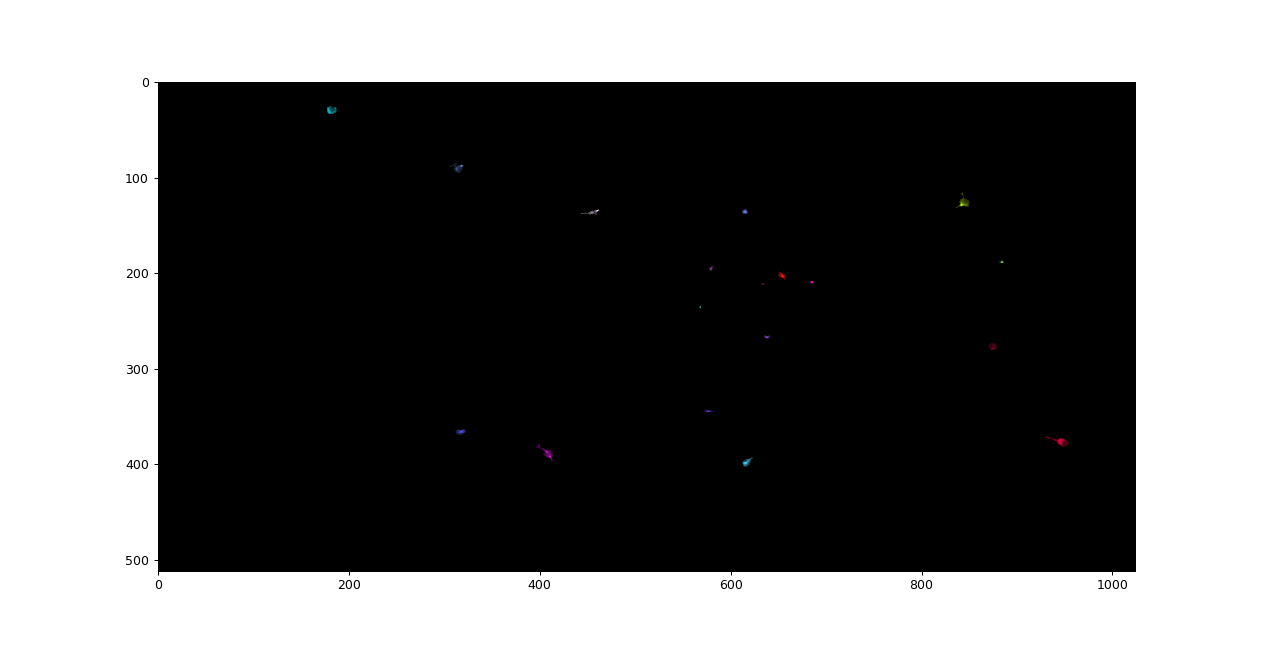

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [102]:
%matplotlib notebook
from ipywidgets import *

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
imshow_FOV = ax.imshow(FOV_all_noClip[0], interpolation='none')

def update(i_frame = 0):
    fig.canvas.draw_idle()
    imshow_FOV.set_data(FOV_all_noClip[i_frame])


interact(update, i_frame=widgets.IntSlider(min=0, max=FOV_all.shape[0]-1, step=1, value=0));

outputs:
`UCIDs`
`UCIDs_bySession`

In [ ]:
pickle_helpers.simple_save(
    {
    "UCIDs": UCIDs,
    "UCIDs_bySession": UCIDs_bySession,
    },
#     filename='/home/rich/Desktop/UCIDs_valerio_20220123.pkl'
#     filename='/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/UCIDs.pkl'
)